In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install gdown

In [3]:
!gdown --id 1paVMxtKtXs5f76P0dQTuXnmdN5q1c6Yn

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1paVMxtKtXs5f76P0dQTuXnmdN5q1c6Yn
From (redirected): https://drive.google.com/uc?id=1paVMxtKtXs5f76P0dQTuXnmdN5q1c6Yn&confirm=t&uuid=83e8127e-d111-44d2-812b-98d85e7c4b5e
To: /kaggle/working/DATA_SV_ver2.zip
100%|███████████████████████████████████████| 3.61G/3.61G [00:17<00:00, 208MB/s]


In [4]:
!unzip -q DATA_SV_ver2.zip > /dev/null 2>&1

In [5]:
TIMESTEPS_IN = 6
TIMESTEPS_OUT = 3
SAMPLES_PER_DAY = 8
KERNEL_SIZE_VALUE = 3
LEARNING_RATE = 0.001
EPOCHS = 60
BATCH_SIZE = 16

In [6]:
import os
import glob
import numpy as np
from PIL import Image

# Path to the month folder (e.g., 'path/to/04' for April)
years = [2019, 2020]
months = [4, 10]

TOTAL_TIMESTEPS = TIMESTEPS_IN + TIMESTEPS_OUT

base_folder = 'DATA_SV/Precipitation/AWS'

# Initialize lists to store X and y data
X_data = []
y_data = []

for year in years:
    for month in months:
        month_folder = os.path.join(base_folder, str(year), str(month).zfill(2))
        
        # Loop over each day's folder (30 folders for each day in the month)
        for day in sorted(os.listdir(month_folder)):
            day_folder = os.path.join(month_folder, day)

            # Collect daily images in chronological order
            daily_images = []

            for img_path in sorted(glob.glob(os.path.join(day_folder, 'AWS_*.tif'))):
                # Open the image and convert to numpy array
                img = Image.open(img_path)
                img_array = np.array(img)

                # Check image dimensions
                if img_array.shape != (90, 250):
                    raise ValueError(f"Unexpected image shape: {img_array.shape}")

                # Add a channel dimension and append to daily_images
                daily_images.append(img_array[..., np.newaxis])  # Shape: (90, 250, 1)

            # Group daily images into chunks of 12 timesteps (9 for input, 3 for output)
            for i in range(0, len(daily_images) - TOTAL_TIMESTEPS + 1, int(24 / SAMPLES_PER_DAY)):
                # Ensure there are exactly 12 images per sample
                if len(daily_images[i:i + TOTAL_TIMESTEPS]) == TOTAL_TIMESTEPS:
                    # Split into X and y parts
                    X_data.append(np.array(daily_images[i:i + TIMESTEPS_IN]))  # First 9 timesteps for X
                    y_data.append(np.array(daily_images[i + TIMESTEPS_OUT:i + TOTAL_TIMESTEPS]))  # Last 3 timesteps for y

# Convert X_data and y_data lists to numpy arrays suitable for ConvLSTM input
# X shape: (samples, 9, 90, 250, 1), y shape: (samples, 3, 90, 250, 1)
X_data = np.array(X_data)
y_data = np.array(y_data)

print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)

X_data shape: (686, 6, 90, 250, 1)
y_data shape: (686, 6, 90, 250, 1)


In [7]:
X_data = np.nan_to_num(X_data, neginf=0)  # Replaces -inf with 0
y_data = np.nan_to_num(y_data, neginf=0)  # Replaces -inf with 0

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.15, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (583, 6, 90, 250, 1)
y_train shape: (583, 6, 90, 250, 1)


In [9]:
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Conv3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras import backend as K
# Build the ConvLSTM model
model = Sequential([
    Input(shape=(None, *X_train.shape[2:])),
    ConvLSTM2D(filters=32, kernel_size=(KERNEL_SIZE_VALUE, KERNEL_SIZE_VALUE), activation='relu',
               padding='same', return_sequences=True),
    BatchNormalization(),

    ConvLSTM2D(filters=32, kernel_size=(KERNEL_SIZE_VALUE, KERNEL_SIZE_VALUE), activation='relu',
               padding='same', return_sequences=True),
    BatchNormalization(),

    ConvLSTM2D(filters=32, kernel_size=(KERNEL_SIZE_VALUE, KERNEL_SIZE_VALUE), activation='relu',
               padding='same', return_sequences=True),
    BatchNormalization(),

    # Change Conv3D to Conv2D as output layer for spatial prediction
    Conv3D(filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same')
])

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, None, 90, 250,  │        38,144 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 90, 250,  │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, None, 90, 250,  │        73,856 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 90, 250,  │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, None, 90, 250,  │        73,856 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, 90, 250,  │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, None, 90, 250,  │           865 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,105 (730.88 KB)

 Trainable params: 186,913 (730.13 KB)

 Non-trainable params: 192 (768.00 B)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='ConvLSTM.keras', 
    monitor='val_loss',        
    mode='min',
    save_best_only=True, 
    verbose=1
)

In [11]:
# Train model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[checkpoint_callback])

Epoch 1/60


I0000 00:00:1733369523.585410     105 service.cc:145] XLA service 0x5b8296076560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733369523.585494     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733369523.585501     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733369532.086981     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2099
Epoch 1: val_loss improved from inf to 0.17593, saving model to ConvLSTM.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.2074 - val_loss: 0.1759
Epoch 2/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0527
Epoch 2: val_loss improved from 0.17593 to 0.06535, saving model to ConvLSTM.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.0528 - val_loss: 0.0653
Epoch 3/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0532
Epoch 3: val_loss improved from 0.06535 to 0.05183, saving model to ConvLSTM.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 0.0532 - val_loss: 0.0518
Epoch 4/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0524
Epoch 4: val_loss improved from 0.05183 to 0.04629, saving model to ConvLSTM.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.0524 - val_loss: 0.0463
Epoch 5/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0637
Epoch 5: val_loss improved from 0.04629 to 0.04203, saving model to Con

KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

NameError: name 'history' is not defined

In [14]:
model = load_model('ConvLSTM.keras')

In [15]:
y_test_pred = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step  


In [ ]:
y_test_pred.shape

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import numpy as np

# Flatten the arrays to calculate the metrics
y_test_flat = y_test.flatten()  # Shape: (24 * 90 * 250,)
predictions_flat = y_test_pred.flatten()  # Shape: (24 * 90 * 250,)

# Calculate MSE, MAE, RMSE, R2 Score, MAPE
mse = mean_squared_error(y_test_flat, predictions_flat)
mae = mean_absolute_error(y_test_flat, predictions_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_flat, predictions_flat)

# Calculate MAPE and handle potential zero values
epsilon = 1e-10  # small value to avoid division by zero
mape = np.mean(np.abs((y_test_flat - predictions_flat) / (y_test_flat + epsilon))) * 100

# Calculate Pearson correlation coefficient
pearson_r, _ = pearsonr(y_test_flat, predictions_flat)

# Print metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")
print("Pearson Correlation Coefficient (r):", pearson_r)

Mean Squared Error (MSE): 0.046347626
Mean Absolute Error (MAE): 0.0075753075
Root Mean Squared Error (RMSE): 0.21528499
R-squared (R2): 0.07512477705801668
Mean Absolute Percentage Error (MAPE): 4508921200.0 %
Pearson Correlation Coefficient (r): 0.32993659513677315


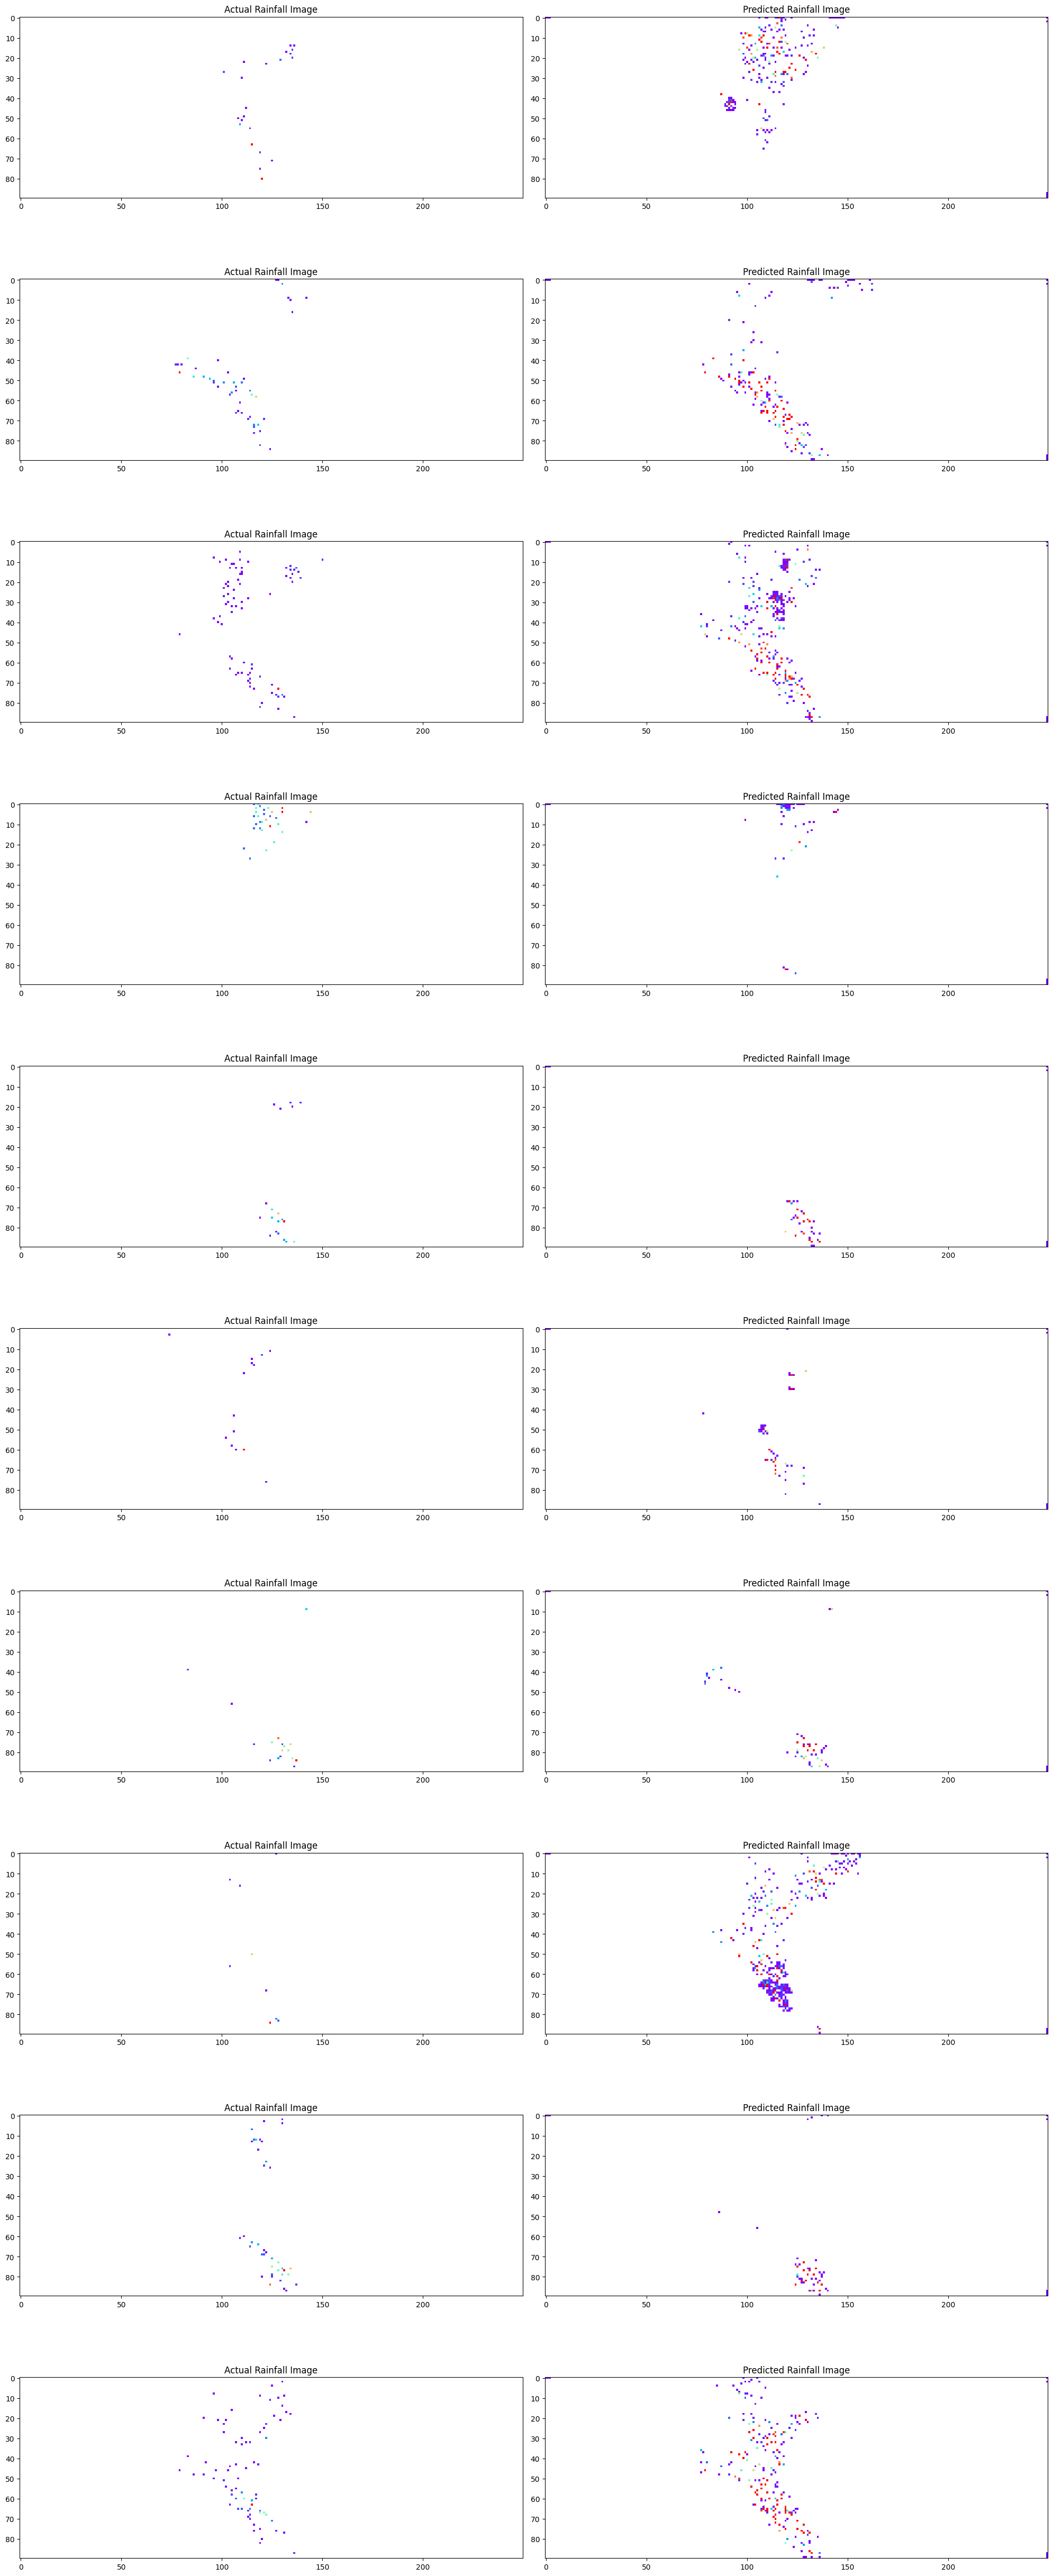

In [17]:


num_examples = 10  # Number of examples to visualize
plt.figure(figsize=(20, 5 * num_examples))

for i in range(num_examples):
    # Plot actual image
    actual_image = y_test[i][TIMESTEPS_IN - TIMESTEPS_OUT].reshape(90, 250)
    masked_actual_image = np.ma.masked_where(actual_image <= 0.001, actual_image)
    cmap = plt.cm.rainbow
    cmap.set_bad(color='white')
    plt.subplot(num_examples, 2, i * 2 + 1)
    plt.imshow(masked_actual_image, cmap=cmap)  # Actual
    plt.title('Actual Rainfall Image')
    plt.axis('on')

    # Plot predicted image
    predicted_image = y_test_pred[i][TIMESTEPS_IN - TIMESTEPS_OUT].reshape(90, 250)
    masked_predicted_image = np.ma.masked_where(predicted_image <= 0.01, predicted_image)
    cmap = plt.cm.rainbow
    cmap.set_bad(color='white')
    plt.subplot(num_examples, 2, i * 2 + 2)
    plt.imshow(masked_predicted_image, cmap=cmap)  # Prediction
    plt.title('Predicted Rainfall Image')
    plt.axis('on')

plt.tight_layout()
plt.show()